In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

### Data Input

In [15]:
#load data
d = pd.read_csv('rab5traj.csv')

uid = np.unique(d['pid'])
data = d[d['pid']==11]
# data = d[d['pid']==15]
# data = d[d['pid']==24]
# data = d[d['pid']==33]
    
def downsample(data_input, down_int, start_index=0):
    
    data_out = data_input.iloc[start_index::down_int]
    return data_out

### Displacements and exponent prediction

In [16]:
#load neural network model
model = tf.keras.models.load_model("model3dense_n20.h5")

def find_displacement(x_data,y_data,start_index=0):
#calculate displacements
    #x_data = np.array(x_data.data)
    #y_data = np.array(y_data.data)
    disps = np.sqrt(np.power(x_data-x_data[0],2) + np.power(y_data-y_data[0],2))
    
    return disps 


def estimate_hurst(disps,time):
    
    h = np.array([])
    ht = np.array([])
    for i in range(10,len(disps)-11):
        #sample of 20 points to calculate hurst exponent for
        inx = disps[(i-10):(i+11)]
        #apply differencing and normalization on the data
        inx = np.array([(inx[1:]-inx[0:-1])/(np.amax(inx)-np.amin(inx))])
        test = model.predict(inx,verbose=0)
        h=np.append(h,test[0][0])
        ht = np.append(ht,time[i])
        
    return h,ht

In [22]:
def dsample_disp(data_in,ds_rate):
    """
    Args:
        data_in: pandas dataframe
        ds_rate: int, downsampling step size
    Returns:
        disp_arr: 2D np array
        t_arr: 2D np array
    """
    
    disp_arr = np.empty((ds_rate,(len(data_in)//ds_rate)))
    t_arr = np.empty((ds_rate,(len(data_in)//ds_rate)))
    
    for i in np.arange(ds_rate):
        
        downsampled_data = downsample(data_in, ds_rate, i)
        x = np.array(downsampled_data['x'])
        y = np.array(downsampled_data['y'])
        t = np.array(downsampled_data['t'])
        disp = find_displacement(x,y)
        
        if len(disp)>np.shape(disp_arr)[1]:
            disp=disp[:-1]
            t=t[:-1]
            
        disp_arr[i] = disp
        t_arr[i] = t
        
    return disp_arr, t_arr


def average_disp(disp_arr, t_arr):
    """
    """
    disp_average_arr = np.mean(disp_arr, axis=0)
    t_average_arr = np.mean(t_arr, axis=0)
    
    return disp_average_arr, t_average_arr

In [27]:
disp2, t2 = dsample_disp(data, 2)
disp_av2, t_av2 = average_disp(disp2, t2)
h2, ht2 = estimate_hurst(disp_av2, t_av2)

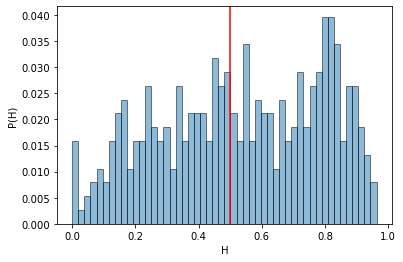

In [28]:
def plot_hist_2D(h, ht, nbins):
    """
    """
    counts, bins = np.histogram(h, nbins)
    normalised_counts = counts/len(h)
    plt.hist(bins[:-1], bins, weights=normalised_counts, alpha=0.5, ec='black')
    
    plt.xlabel('H')
    plt.ylabel('P(H)')
    plt.axvline(0.5, color='r')
    plt.show()

%matplotlib inline
plt.figure()
plot_hist_2D(h2, ht2, 50)
#plot_hist_2D(h3, ht3, 50)
plt.show()

### 3D histogram

3D histogram:<br>
x axis is H.<br>
y axis is step size used for that downsampled data set.<br>
z axis is normalised average counts.<br>

In [29]:
def get_3D_hist_data(data_in, step_sizes, nbins):
    """
    Args:
        data_in: pandas dataframe
        step_sizes: array of int
        nbins: int, number of histogram bins
    Returns:
        normalised_counts_all: 2D np array, each row is normalised average counts for a given step size
        bins_all: 2D np array, each row is bin edges for a given step size
    """
    normalised_counts_all = np.empty((len(step_sizes), nbins))
    bins_all = np.empty((len(step_sizes), nbins+1))
    
    for i, s in enumerate(step_sizes):
        disp_arr, t_arr = dsample_disp(data_in, s)
        disp_av_arr, t_av_arr = average_disp(disp_arr, t_arr)
        h, t = estimate_hurst(disp_av_arr, t_av_arr)
        counts, bins = np.histogram(h, nbins)
        normalised_counts = counts/len(h)
        normalised_counts_all[i] = normalised_counts
        bins_all[i] = bins
        
    return normalised_counts_all, bins_all

In [30]:
step_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
nbins = 50
hist = get_3D_hist_data(data, step_sizes, nbins)

<IPython.core.display.Javascript object>


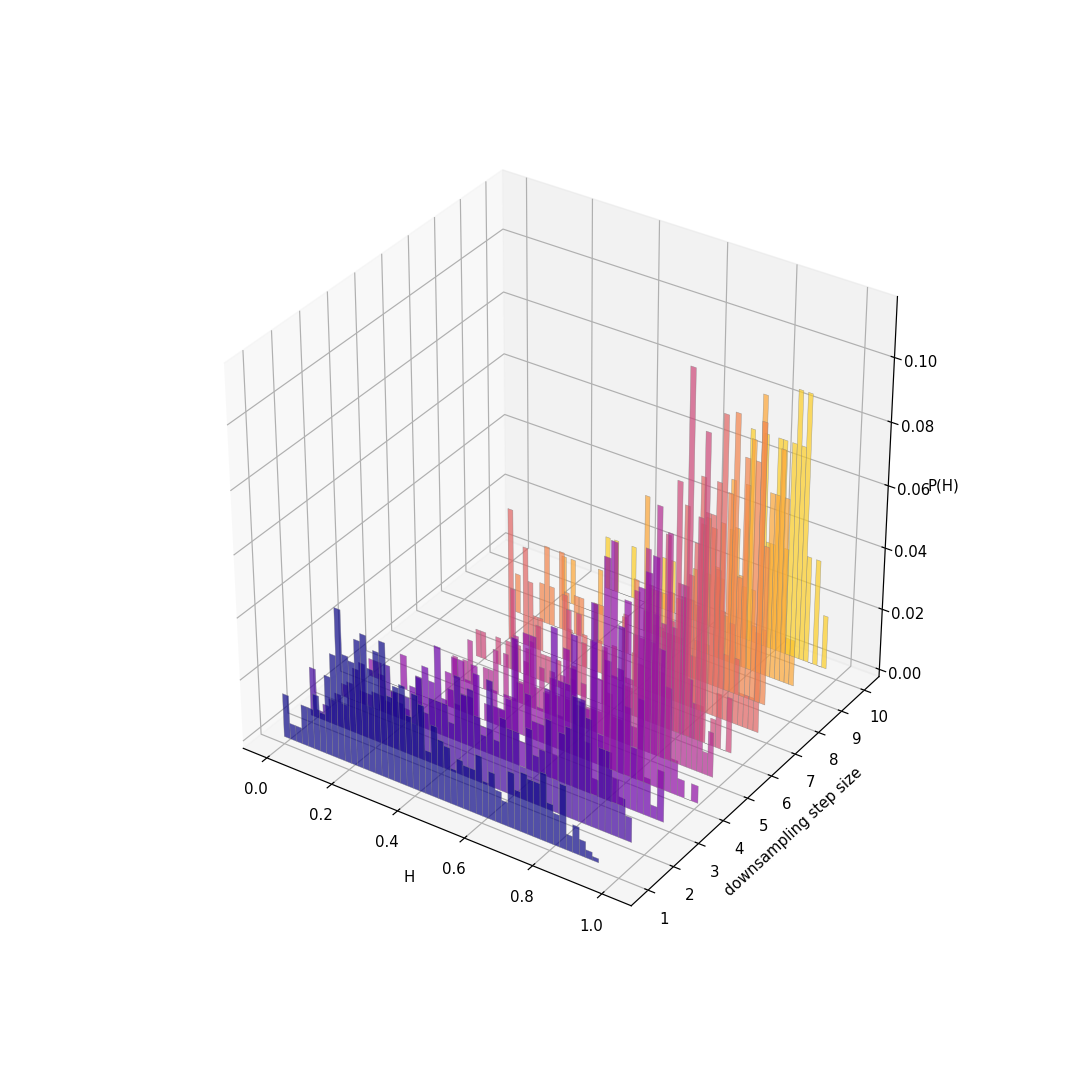

In [34]:
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")

cmap = plt.cm.plasma

yticks = np.array(step_sizes)

for i, s in enumerate(step_sizes):
    ytick = yticks[i]
    normalised_counts = hist[0][i]
    bins = hist[1][i]
    xcenter = np.convolve(bins, np.ones(2), "valid")/2
    xwidth = np.diff(bins)
    ax.bar(left=xcenter, height=normalised_counts, width=xwidth, zs=ytick, zdir="y", color=cmap(i/len(yticks)), alpha=0.7, edgecolor="grey", linewidth=0.3)
    
ax.set_xlabel("H")
ax.set_ylabel("downsampling step size")
ax.set_zlabel("P(H)")

ax.set_yticks(yticks)
plt.show()